# This Notebook Perform two things...........

# 1 Section:                                                                 
Research Area Subject Area Prediction (Large Scale classification) using shallow Multi-Layer Perceptron (MLP) model

# 2 Section:
Research Paper Recommendation for reading: using sentence transformer model

Research Papers dataset link::
https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts/data


# 1 Section:                                                                 

# Loading tools and dataset

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval
# is used for safely evaluating strings containing Python literals or container displays
# (e.g., lists, dictionaries) to their corresponding Python objects.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
arxiv_data = pd.read_csv("arxiv_data_210930-054931.csv")

In [3]:
arxiv_data.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


# Data Cleaning and Preprocessing

In [4]:
arxiv_data.shape

(56181, 3)

In [5]:
arxiv_data.isnull().sum()

terms        0
titles       0
abstracts    0
dtype: int64

In [6]:
arxiv_data.duplicated().sum()

15054

In [7]:
# getting unique labels
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("lenght :",len(labels))

labels : ['cs.LG' 'cs.AI' 'cs.CR' ... 'D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3'
 '68T07, 68T45, 68T10, 68T50, 68U35' 'I.2.0; G.3']
lenght : 1177


In [8]:
# remove duplicate entries based on the "titles" (terms) column
# This filters the DataFrame, keeping only the rows where the titles are not duplicated.
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data['terms'].value_counts()==1))
# how many unique terms
print(arxiv_data['terms'].nunique())

There are 41105 rows in the deduplicated dataset.
2503
3401


In [9]:
# Filtering the rare terms. (it keeps only those rows where the "terms" value occurs more than once in the original DataFrame.)
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(38602, 3)

In [10]:
# It evaluates the given string containing a Python literal or container display (e.g., a list or dictionary) and returns the corresponding Python object.
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.LG']), list(['cs.LG', 'cs.AI']),
       list(['cs.LG', 'cs.CR', 'stat.ML'])], dtype=object)

# train and test split.

In [11]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 34741
Number of rows in validation set: 1930
Number of rows in test set: 1931


In [12]:
# creates a TensorFlow RaggedTensor (terms) from the values in the "terms" column of the train_df DataFrame. A RaggedTensor is a tensor with non-uniform shapes
terms = tf.ragged.constant(train_df['terms'].values)
# This line creates a StringLookup layer in TensorFlow. The purpose of this layer is to map strings to integer indices and vice versa. The output_mode="multi_hot" indicates that the layer will output a multi-hot encoded representation of the input strings.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
# This step adapts the StringLookup layer to the unique values in the "terms" column, building the vocabulary.
lookup.adapt(terms)
# retrieve vocabulary
vocab = lookup.get_vocabulary()

print("Vocabulary:\n")
print(vocab)



Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.GR', 'cs.CR', 'math.OC', 'eess.SP', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'eess.SY', 'cs.MA', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'stat.AP', 'cs.CY', 'stat.ME', 'stat.TH', 'math.ST', 'eess.AS', 'cs.DS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'stat.CO', 'cs.CG', 'cs.NI', 'cs.GT', 'math.NA', 'cs.SE', 'I.2.6', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'physics.comp-ph', 'cond-mat.dis-nn', 'q-bio.BM', 'math.PR', 'cs.PL', 'cs.LO', '68T45', 'cs.AR', 'physics.data-an', 'quant-ph', 'I.2.10', 'cs.CE', 'cond-mat.stat-mech', 'q-fin.ST', 'I.4.6', 'physics.ao-ph', 'math.DS', 'cs.CC', '68T05', 'physics.soc-ph', 'physics.med-ph', 'cs.PF', 'econ.EM', 'cs.DM', 'I.4.8', 'q-bio.GN', 'astro-ph.IM', 'physics.flu-dyn', 'math.AT', 'hep-ex', 'I.4', '68U10', 'q-fin.TR', 'physics.geo-ph', 'cs.FL', 'I.5.4', 'I.2', 'cond-mat.mtrl-sci', 'I.4.9', '68T10', 'q-fin.CP', 'physics.optics', 'I.4; I.5', '68T07', 'math.AP', 'I.2.6

In [13]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'cs.AI']
Label-binarized representation: [[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [14]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [15]:
# following lines::
# which is used for automatic adjustment of resource usage by TensorFlow's data loading pipeline.

#max_seqlen: Maximum sequence length. It indicates the maximum length allowed for sequences.
max_seqlen = 150
#batch_size: Batch size. It specifies the number of samples to use in each iteration.
batch_size = 128
#padding_token: A token used for padding sequences.
padding_token = "<pad>"
#auto = tf.data.AUTOTUNE: auto is assigned the value tf.data.AUTOTUNE,
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    # creating sequences of labesls
    labels = tf.ragged.constant(dataframe["terms"].values)
    #This line uses the previously defined lookup layer to convert the ragged tensor of labels into a binarized representation. The resulting label_binarized is a NumPy array.
    label_binarized = lookup(labels).numpy()
    # creating sequences of text.
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["abstracts"].values, label_binarized))
    # shuffling data basis on condition
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

"""
In summary, the make_dataset function is designed to create a 
dataset suitable for training a model. It takes a dataframe as input, 
assumes it has "abstracts" and "terms" columns, and creates a dataset of 
batches where each batch consists of abstract 
sequences and their corresponding binarized label sequences. 
"""

'\nIn summary, the make_dataset function is designed to create a \ndataset suitable for training a model. It takes a dataframe as input, \nassumes it has "abstracts" and "terms" columns, and creates a dataset of \nbatches where each batch consists of abstract \nsequences and their corresponding binarized label sequences. \n'

In [16]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [17]:
# This code snippet is iterating through batches of the training dataset and printing the abstract text along with the corresponding labels.
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'We present Border-SegGCN, a novel architecture to improve semantic\nsegmentation by refining the border outline using graph convolutional networks\n(GCN). The semantic segmentation network such as Unet or DeepLabV3+ is used as\na base network to have pre-segmented output. This output is converted into a\ngraphical structure and fed into the GCN to improve the border pixel prediction\nof the pre-segmented output. We explored and studied the factors such as border\nthickness, number of edges for a node, and the number of features to be fed\ninto the GCN by performing experiments. We demonstrate the effectiveness of the\nBorder-SegGCN on the CamVid and Carla dataset, achieving a test set performance\nof 81.96% without any post-processing on CamVid dataset. It is higher than the\nreported state of the art mIoU achieved on CamVid dataset by 0.404%'
Label(s): ['cs.CV' 'cs.AI']
 
Abstract: b'Fine-grained 3D shape retrieval aims to retrieve 3D shapes similar to a query\nshape in a 

In [18]:
# This code calculates the size of the vocabulary in the "abstracts" column of the train_df DataFrame.

# Creating vocabulary with uniques words
vocabulary = set()
train_df["abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

159077


# Text Vectorization

In [19]:
# Initializes a TextVectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size,ngrams=2,output_mode="tf_idf")
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [20]:
"""
Mapping Vectorization to Datasets: The code maps the text vectorization operation to 
each element of the training, validation, and test datasets. This ensures that the text
data in each dataset is transformed into numerical vectors using the adapted TextVectorization layer.
The num_parallel_calls parameter is used to parallelize the mapping process, and prefetch is 
applied to prefetch data batches 
for better performance.
"""
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

# model training

In [21]:
# creating shallow_mlp_model  (MLP)
from tensorflow.keras.callbacks import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])


Epoch 1/20

272/272 [==============================] - 493s 2s/step - loss: 0.0471 - binary_accuracy: 0.9839 - val_loss: 0.0178 - val_binary_accuracy: 0.9949
Epoch 2/20
272/272 [==============================] - 514s 2s/step - loss: 0.0173 - binary_accuracy: 0.9950 - val_loss: 0.0175 - val_binary_accuracy: 0.9949
Epoch 3/20
272/272 [==============================] - 505s 2s/step - loss: 0.0135 - binary_accuracy: 0.9960 - val_loss: 0.0182 - val_binary_accuracy: 0.9947
Epoch 4/20
272/272 [==============================] - 500s 2s/step - loss: 0.0109 - binary_accuracy: 0.9967 - val_loss: 0.0195 - val_binary_accuracy: 0.9947
Epoch 5/20
272/272 [==============================] - 461s 2s/step - loss: 0.0094 - binary_accuracy: 0.9972 - val_loss: 0.0200 - val_binary_accuracy: 0.9948
Epoch 6/20
272/272 [==============================] - 581s 2s/step - loss: 0.0082 - binary_accuracy: 0.9976 - val_loss: 0.0202 - val_binary_accuracy: 0.9947
Epoch 7/20
272/272 [==============================] - 52

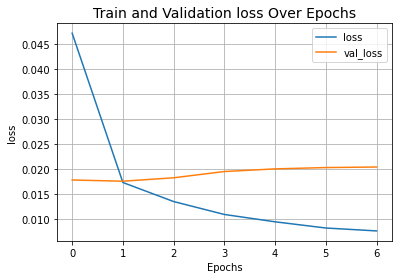

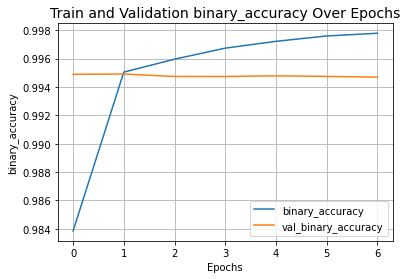

In [22]:
# plotting loss
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

# Model Evaluation

In [23]:
# model evaltuation on test and val dataset
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

16/16 [==============================] - 10s 589ms/step - loss: 0.0175 - binary_accuracy: 0.9949
Categorical accuracy on the test set: 99.44%.
Categorical accuracy on the validation set: 99.49%.


# Model Prediction

In [26]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, model1])
# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

# =======Section 2========

# 2 Recommendation System

In [ ]:
arxiv_data.drop(columns = ["terms","abstracts"], inplace = True)

In [ ]:
arxiv_data.drop_duplicates(inplace= True)
arxiv_data.reset_index(drop= True,inplace = True)

In [ ]:
pd.set_option('display.max_colwidth', None)
arxiv_data

# Sentence Transformers

In [ ]:
# !pip install -U -q sentence-transformers

In [ ]:
# This imports the SentenceTransformer class from the Sentence Transformers library.
from sentence_transformers import SentenceTransformer, util
# This initializes the 'all-MiniLM-L6-v2' model from Sentence Transformers. This model is capable of encoding 
#sentences into fixed-size vectors (embeddings).
model = SentenceTransformer('all-MiniLM-L6-v2')
#Our sentences we like to encode
sentences = arxiv_data['titles']
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

"""
The embeddings can be used for various natural language processing (NLP) tasks, 
such as similarity search, clustering
"""

In [ ]:
embeddings

# Why select all-MiniLM-L6-v2?

All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs. Source

Its small in size 80 MB with good performance.

# Print the embeddings

In [ ]:
c = 0
#This loop iterates over pairs of sentences and their corresponding embeddings. 
#zip is used to iterate over both lists simultaneously.
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding length:", len(embedding)) # list of floats
    print("")
    # Breaks out of the loop after printing information for the first 5 sentences.
    if c >=5:
        break
    c +=1 

# Save files

In [ ]:
import pickle
# Saving sentences and corresponding embeddings
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

with open('sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)
    
with open('rec_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Recommendation for similar papers

In [ ]:
# load save files
embeddings = pickle.load(open('models/embeddings.pkl','rb'))
sentences = pickle.load(open('models/sentences.pkl','rb'))
rec_model = pickle.load(open('models/rec_model.pkl','rb'))

In [ ]:
import torch

def recommendation(input_paper):
    # Calculate cosine similarity scores between the embeddings of input_paper and all papers in the dataset.
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))
    
    # Get the indices of the top-k most similar papers based on cosine similarity.
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)
                                 
    # Retrieve the titles of the top similar papers.
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list


In [ ]:
# exampel usage 1: (use this paper as input (Attention is All you Need))
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

In [ ]:
# exampel usage 2: (use this paper as input (BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding))
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

In [ ]:
# exampel usage 3: (use this paper as input (Review of deep learning: concepts, CNN architectures, challenges, applications, future directions))
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

In [ ]:
# install this versions
import sentence_transformers
import tensorflow
import torch
print(torch.__version__)
print(sentence_transformers.__version__)
print(tensorflow.__version__)